# **Analyzing "Census Adult Income" Dataset**

# Step 1: Import Libraries, Query dataset, and Explore the Dataset


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize BigQuery client (if working with BigQuery)
from google.cloud import bigquery
client = bigquery.Client()

In [2]:
# Corrected query with valid column names
query = """
    SELECT 
        age,
        workclass,
        education,
        marital_status,
        occupation,
        relationship,
        race,
        sex,
        capital_gain,
        capital_loss,
        hours_per_week,
        native_country,
        income_bracket
    FROM `bigquery-public-data.ml_datasets.census_adult_income`
"""
query_job = client.query(query)
# Convert query results into a dictionary
results = query_job.result()  # This fetches all the rows from the query
# Load it directly into a pandas DataFrame
df = pd.DataFrame([dict(row) for row in results])
print(df.head())


   age workclass education       marital_status          occupation  \
0   39   Private       9th   Married-civ-spouse       Other-service   
1   77   Private       9th   Married-civ-spouse     Priv-house-serv   
2   38   Private       9th   Married-civ-spouse       Other-service   
3   28   Private       9th   Married-civ-spouse     Protective-serv   
4   37   Private       9th   Married-civ-spouse   Machine-op-inspct   

  relationship    race      sex  capital_gain  capital_loss  hours_per_week  \
0         Wife   Black   Female          3411             0              34   
1         Wife   Black   Female             0             0              10   
2         Wife   Black   Female             0             0              24   
3         Wife   Black   Female             0             0              40   
4         Wife   Black   Female             0             0              48   

   native_country income_bracket  
0   United-States          <=50K  
1   United-States          <

In [3]:
# Check the structure of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital_status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital_gain    32561 non-null  int64 
 9   capital_loss    32561 non-null  int64 
 10  hours_per_week  32561 non-null  int64 
 11  native_country  32561 non-null  object
 12  income_bracket  32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB
None


In [4]:
# Check the structure of the DataFrame
print(df.describe())

                age  capital_gain  capital_loss  hours_per_week
count  32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647   1077.648844     87.303830       40.437456
std       13.640433   7385.292085    402.960219       12.347429
min       17.000000      0.000000      0.000000        1.000000
25%       28.000000      0.000000      0.000000       40.000000
50%       37.000000      0.000000      0.000000       40.000000
75%       48.000000      0.000000      0.000000       45.000000
max       90.000000  99999.000000   4356.000000       99.000000


In [5]:
# Count the number of unique values in each column
unique_counts = df.nunique()

# Print the unique counts for each column
print(unique_counts)

age                73
workclass           9
education          16
marital_status      7
occupation         15
relationship        6
race                5
sex                 2
capital_gain      119
capital_loss       92
hours_per_week     94
native_country     42
income_bracket      2
dtype: int64


# Step 2: Data Cleaning

1. Check the missing values

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age               0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64


2. Check the duplicates

In [7]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 3465


In [8]:
# Alternatively, if you want to modify the DataFrame in place
df.drop_duplicates(inplace=True)

In [9]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


3. Handling the Data Types

In [10]:
import pandas as pd

# Convert numerical columns explicitly (if necessary)
numerical_columns = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric)

# Convert categorical columns to 'category' type
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation',
                       'relationship', 'race', 'sex', 'native_country', 'income_bracket']
df[categorical_columns] = df[categorical_columns].apply(lambda col: col.astype('category'))

# Verify changes
print("\nUpdated data types:")
print(df.dtypes)



Updated data types:
age                  int64
workclass         category
education         category
marital_status    category
occupation        category
relationship      category
race              category
sex               category
capital_gain         int64
capital_loss         int64
hours_per_week       int64
native_country    category
income_bracket    category
dtype: object


In [11]:
# Check for any anomalies (e.g., unexpected missing or unique values after conversion)
print("\nUnique values in categorical columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
workclass: 9 unique values
education: 16 unique values
marital_status: 7 unique values
occupation: 15 unique values
relationship: 6 unique values
race: 5 unique values
sex: 2 unique values
native_country: 42 unique values
income_bracket: 2 unique values


4. Addressing Outliers or Anomalies

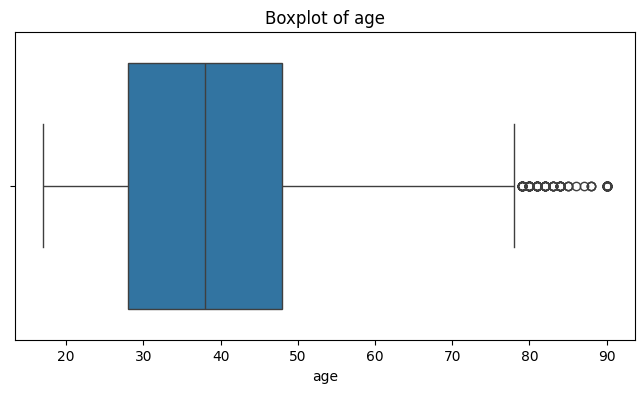

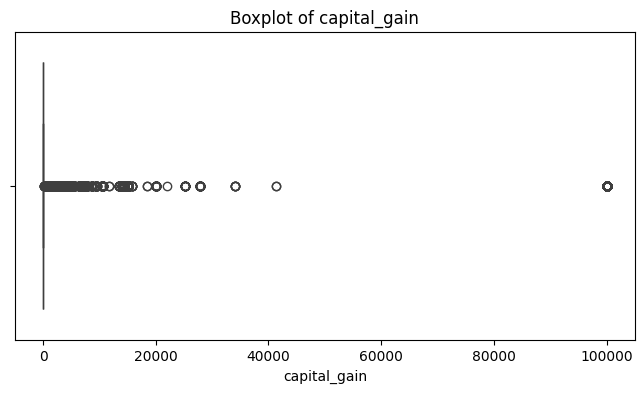

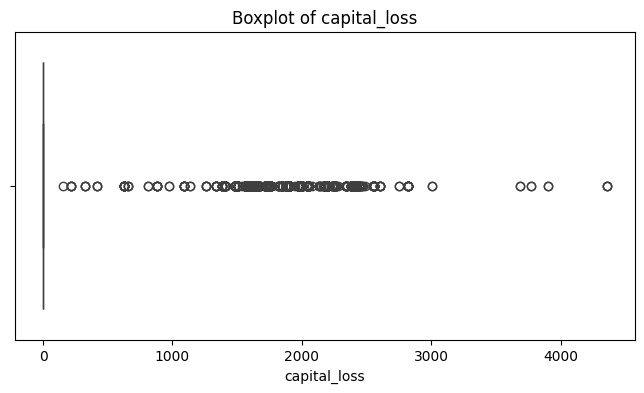

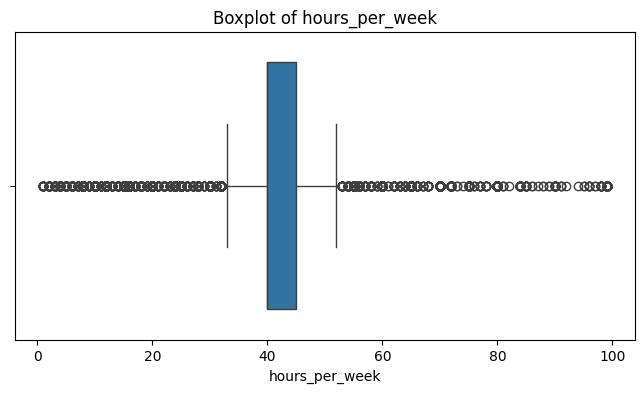

In [12]:
# Visualize potential outliers in numerical columns
numerical_cols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


## **Why we don't remove the outliers?**
### - **Age**
**Reason:** Extreme ages (young or old) reflect real-world variations in income, such as teenagers or retirees. Removing them would ignore valid demographic trends.
**Decision:** Keep outliers for accurate demographic representation.
### - **Capital Gain & Capital Loss**
**Reason:** High capital gain/loss values indicate individuals with investments or unique financial circumstances. These are meaningful and not errors.
**Decision:** Retain outliers to capture financial diversity in income analysis.
### - **Hours Per Week**
**Reason:** Extremely high or low working hours represent diverse work patterns, such as part-time, full-time, or overtime workers. Removing these would discard important data.
**Decision:** Keep outliers to reflect the full spectrum of working hours.

5. Cleaning Up Invalid or Inconsistent Entries

In [13]:
# Identify unique values in categorical columns
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].unique())

Unique values in workclass:
[' Private', ' ?', ' Local-gov', ' Self-emp-inc', ' Federal-gov', ' State-gov', ' Self-emp-not-inc', ' Never-worked', ' Without-pay']
Categories (9, object): [' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ..., ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay']
Unique values in education:
[' 9th', ' 10th', ' 11th', ' 12th', ' 1st-4th', ..., ' Doctorate', ' Preschool', ' Assoc-acdm', ' Prof-school', ' Some-college']
Length: 16
Categories (16, object): [' 10th', ' 11th', ' 12th', ' 1st-4th', ..., ' Masters', ' Preschool', ' Prof-school', ' Some-college']
Unique values in marital_status:
[' Married-civ-spouse', ' Separated', ' Never-married', ' Divorced', ' Married-spouse-absent', ' Widowed', ' Married-AF-spouse']
Categories (7, object): [' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed']
Unique values in occupation:
[' Other-service', ' Priv-house-serv', ' Prote

In [14]:
# Correcting variations or typos in 'workclass' category
df['workclass'] = df['workclass'].replace({
    'self-emp-not-inc': 'self-employed',
    'self-emp-inc': 'self-employed'
})

# Standardizing the 'marital_status' categories for consistency
df['marital_status'] = df['marital_status'].replace({
    'married-civ-spouse': 'married',
    'married-spouse-absent': 'married',
    'married-AF-spouse': 'married'
})

df['occupation'] = df['occupation'].replace({
    'machine-op-inspct': 'machine-operation-inspctor',
    'exec-managerial': 'executive',
    'adm-clerical': 'Administrative'
})

df['education'] = df['education'].replace({
    '9th grade': '9th',
    '10th grade': '10th',
    '11th grade': '11th',
    '12th grade': '12th',
    '1st-4th': 'elementary school',
    '5th-6th': 'elementary school',
    '7th-8th': 'middle school',
    'assoc-voc': 'associate\'s degree vocational',
    'assoc-acdm': 'associate\'s degree academic',
    'prof-school': 'professional school',
    'some-college': 'some college'
})


# Checking for unexpected or invalid categories in 'native_country'
df['native_country'] = df['native_country'].replace({'unknown': 'Other'})

# Standardize Text Columns to Lowercase
# Convert other text-based columns to lowercase to avoid inconsistencies.
df['workclass'] = df['workclass'].str.lower()  # Convert 'workclass' to lowercase
df['education'] = df['education'].str.lower()  # Convert 'education' to lowercase
df['marital_status'] = df['marital_status'].str.lower()  # Convert 'marital_status' to lowercase
df['occupation'] = df['occupation'].str.lower()  # Convert 'occupation' to lowercase
df['relationship'] = df['relationship'].str.lower()  # Convert 'relationship' to lowercase
df['race'] = df['race'].str.lower()  # Convert 'race' to lowercase
df['sex'] = df['sex'].str.lower()  # Convert 'sex' to lowercase
df['native_country'] = df['native_country'].str.lower()


# Strip Whitespace from Categorical Columns
# Removing leading/trailing spaces in categorical data to avoid mismatches
df['education'] = df['education'].str.strip()  # Remove extra spaces from 'education'
df['workclass'] = df['workclass'].str.strip()  # Remove extra spaces from 'workclass'
df['marital_status'] = df['marital_status'].str.strip()  # Remove extra spaces from 'marital_status'
df['occupation'] = df['occupation'].str.strip()  # Remove extra spaces from 'occupation'
df['native_country'] = df['native_country'].str.strip()  
df['relationship'] = df['relationship'].str.strip()
df['race'] = df['race'].str.strip()
df['sex'] = df['sex'].str.strip()


# Print a summary of the changes made
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].unique())



Unique values in workclass:
['private' '?' 'local-gov' 'self-emp-inc' 'federal-gov' 'state-gov'
 'self-emp-not-inc' 'never-worked' 'without-pay']
Unique values in education:
['9th' '10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' 'hs-grad'
 'masters' 'assoc-voc' 'bachelors' 'doctorate' 'preschool' 'assoc-acdm'
 'prof-school' 'some-college']
Unique values in marital_status:
['married-civ-spouse' 'separated' 'never-married' 'divorced'
 'married-spouse-absent' 'widowed' 'married-af-spouse']
Unique values in occupation:
['other-service' 'priv-house-serv' 'protective-serv' 'machine-op-inspct'
 '?' 'tech-support' 'exec-managerial' 'farming-fishing' 'adm-clerical'
 'sales' 'craft-repair' 'transport-moving' 'handlers-cleaners'
 'prof-specialty' 'armed-forces']
Unique values in relationship:
['wife' 'husband' 'own-child' 'unmarried' 'not-in-family' 'other-relative']
Unique values in race:
['black' 'white' 'asian-pac-islander' 'other' 'amer-indian-eskimo']
Unique values in sex:
['female' 'male

In [15]:
# Convert all columns to string type and then check for '?' marks
columns_with_question_mark = df.apply(lambda x: x.astype(str).str.contains('\?', na=False).sum(), axis=0)

# Display columns where '?' appears
print(columns_with_question_mark[columns_with_question_mark > 0])


workclass         1632
occupation        1639
native_country     580
dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:2: SyntaxWarning: invalid escape sequence '\?'
C:\Users\Shahd\AppData\Local\Temp\ipykernel_16172\3743376911.py:2: SyntaxWarning: invalid escape sequence '\?'
  columns_with_question_mark = df.apply(lambda x: x.astype(str).str.contains('\?', na=False).sum(), axis=0)


In [16]:
# Convert '?' to NaN
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native_country'] = df['native_country'].replace('?', np.nan)

# Check for NaN values to confirm the conversion
print(df[['workclass', 'occupation', 'native_country']].isna().sum())

workclass         1632
occupation        1639
native_country     580
dtype: int64


In [ ]:
# Impute NaN values with the mode (most frequent value) for each column
df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])
df['native_country'] = df['native_country'].fillna(df['native_country'].mode()[0])

# Check for NaN values to confirm replacing them
print(df[['workclass', 'occupation', 'native_country']].isna().sum())


workclass         0
occupation        0
native_country    0
dtype: int64


# Step 3: Data Visualization
- Create some charts, colleration matrix, heatmap, and any other additional thing you find by your search 
- Write conclusion under each of the chart

## 1) Pairplot (for numerical features)
- It visualizes the pairwise relationships between numerical features, helping to identify potential correlations or patterns.

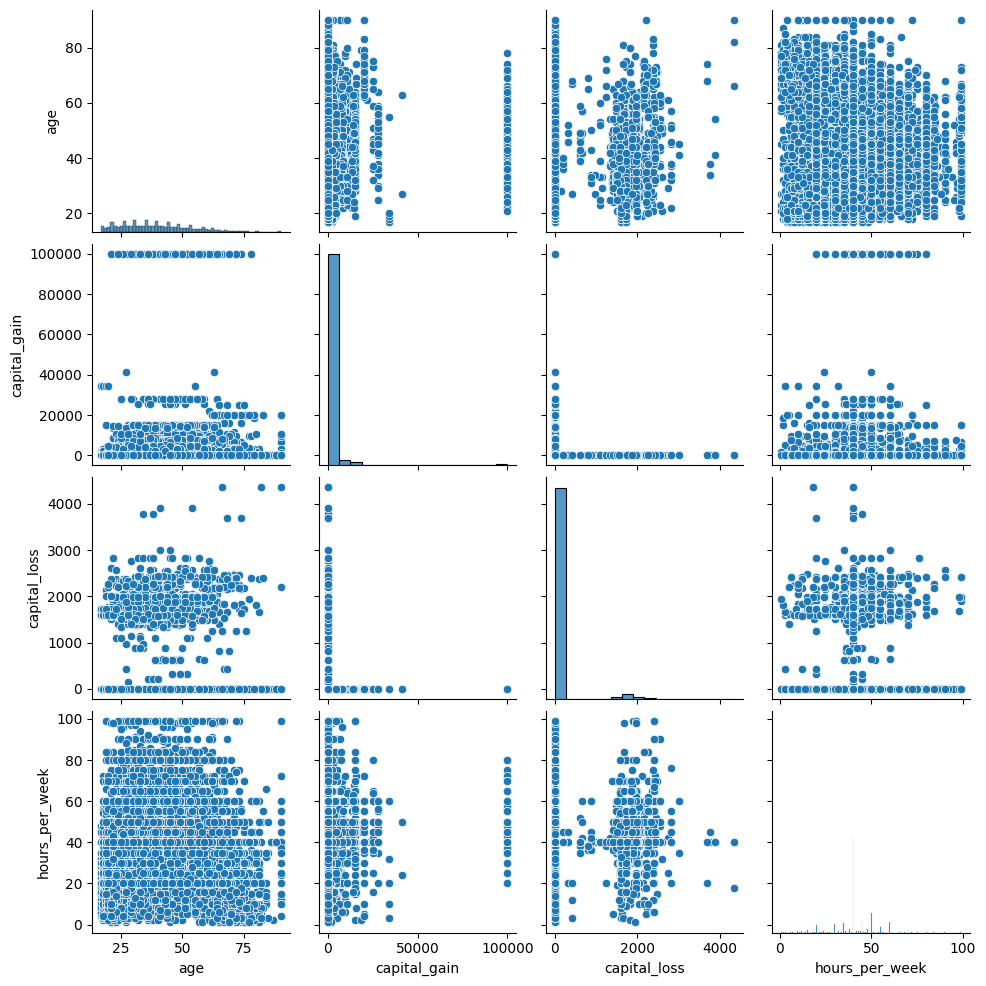

In [18]:
sns.pairplot(df[['age', 'capital_gain', 'capital_loss', 'hours_per_week']])
plt.show()

**Key Findings:**
- There is a relation between "Hours per week of work and Capital gain"
- A potential for relation between "Age and Capital gain"
- A potential for relation "Age and Capital loss"

## 2) Histogram of Age:

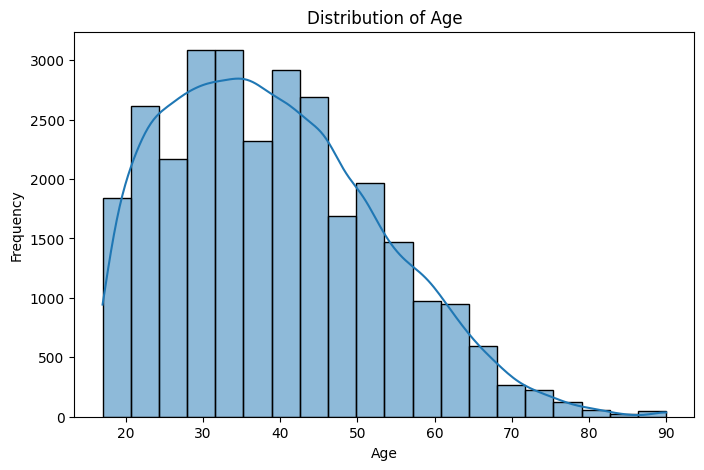

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Key Findings:**
- The most frequent age in workforce is ranging from late 20s to mid 30s
- After mid 30s till mid 40s are also common on the workforce 
- People after 60s are rare to continue working

## 3) scatter plot for Age Capital gain & loss:

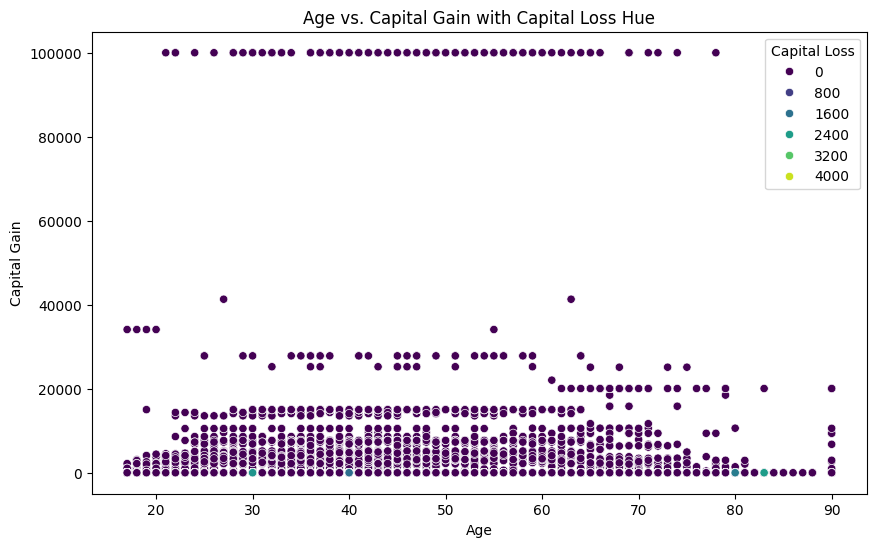

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='capital_gain', hue='capital_loss', data=df, palette='viridis')
plt.title('Age vs. Capital Gain with Capital Loss Hue')
plt.xlabel('Age')
plt.ylabel('Capital Gain')
plt.legend(title='Capital Loss')
plt.show()

**Key findings:**
- No clear relation found

## 4) Boxplot of Hours Per Week by Income Bracket:

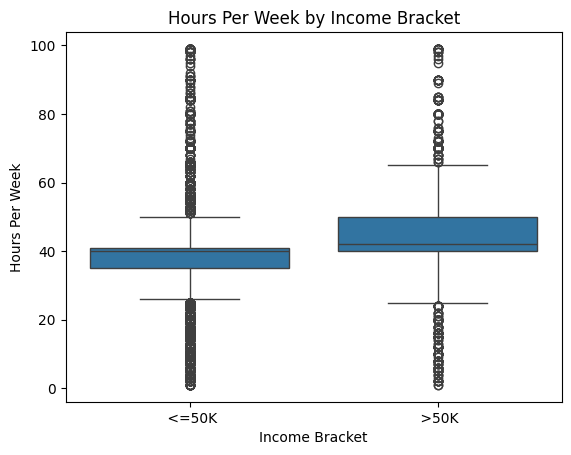

In [21]:
sns.boxplot(x='income_bracket', y='hours_per_week', data=df)
plt.title('Hours Per Week by Income Bracket')
plt.xlabel('Income Bracket')
plt.ylabel('Hours Per Week')
plt.show()

**Key findings:**
- People who work more than 40 hours have an income above 50,000

## 5) Countplot of Income Bracket:

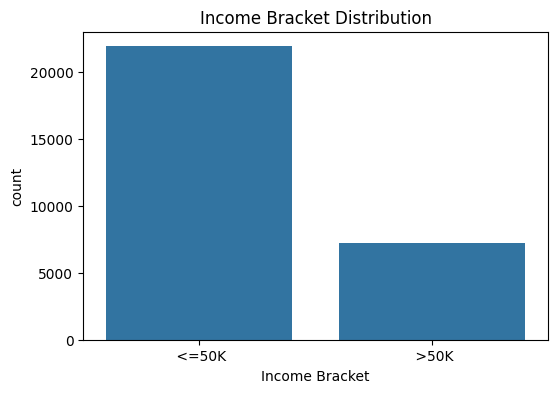

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(x='income_bracket', data=df)
plt.title('Income Bracket Distribution')
plt.xlabel('Income Bracket')
plt.show()

**Key findings:**
- Most people have income less than 50,000

## 6) Barplot of Education vs. Income Bracket:

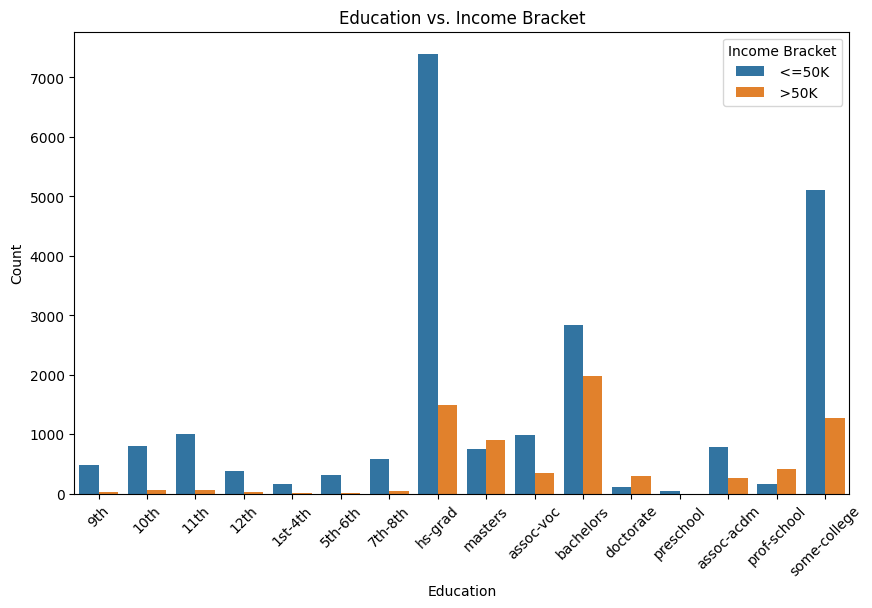

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='income_bracket', data=df)
plt.title('Education vs. Income Bracket')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Income Bracket')
plt.show()

**Key findings:**
- Most High school grads have income less than 50,000
- It is more common for those who have Bachelor degree to get Income greater than 50,000
- People who hold masters degree are more likley to get more than 50,000
- It could be strongly concluded that obtaining a higher degree could greatly increase the income.

## 7) Correlation Matrix and Heatmap:

In [24]:
le = LabelEncoder()
df['income_bracket_encoded'] = le.fit_transform(df['income_bracket']) 
df = pd.get_dummies(df, columns=['income_bracket'], drop_first=True) 
corr_matrix = df[['age', 'hours_per_week', 'income_bracket_encoded']].corr() 
plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title('Correlation Matrix')
plt.show()

NameError: name 'LabelEncoder' is not defined

**Key findings:** 
- A weak positive correlation could be found between age and hours per week.

# Step 4: Data Preprocessing
"Search for steps suitable for the following ML algorithms which are logistic regression and Random Forest algorithms" 
- Encoding categorical data.
- Scaling or normalizing numerical features.
- Feature engineering (e.g., creating or combining features).


## 1. Encoding
Since the dataset contains categorical variables (e.g., workclass, education, occupation, etc.), encoding them into numerical format is necessary.

Use one-hot encoding for categorical variables, as it is universally compatible with both Logistic Regression and Random Forest. While Random Forest can handle label encoding, one-hot encoding avoids any implicit ordinal relationships between categories, which is also crucial for Logistic Regression.

In [25]:
# One-hot encode all categorical columns
df = pd.get_dummies(df, columns=[
    "workclass", "education", "marital_status", "occupation", 
    "relationship", "race", "sex", "native_country", "income_bracket"
], drop_first=True)

## 2. Normalization/Scaling
Apply standardization to continuous numerical features. While Random Forest does not require scaling, applying the same scaling ensures consistency when using both algorithms.

In [26]:
from sklearn.preprocessing import StandardScaler

# List of numerical columns
numerical_columns = ["age", "capital_gain", "capital_loss", "hours_per_week"]

# Apply StandardScaler to normalize numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


## 3. Feature engineering

### 1. Combine Features
a. Age Groups
Create age categories to capture potential nonlinear relationships between age and income.

b. Income-to-Hours Ratio
Calculate the ratio of capital_gain to hours_per_week to capture the productivity of capital gain relative to working hours.

c. Combine Marital Status and Relationship
These two features may have overlapping information. Combine them into a single feature to represent the broader context of household structure

### 2. Transform Features
a. Log Transformation
Apply log transformation to capital_gain and capital_loss to reduce skewness in their distribution.

b. Interaction Features
Create interaction terms between important variables (e.g., education and occupation), as these may jointly influence income.

### 3. Drop Less Informative Features
After creating new features, drop redundant or less informative columns, such as:

- The original capital_gain and capital_loss columns after log transformation.
- Redundant categorical columns if combined features are more informative.

In [27]:
# Age groups
bins = [0, 25, 45, 65, 100]
labels = ["Youth", "Adult", "Middle-aged", "Senior"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

# Capital gain per hour
df["capital_gain_per_hour"] = df["capital_gain"] / (df["hours_per_week"] + 1)

# Log transformation for skewed data
df["log_capital_gain"] = np.log1p(df["capital_gain"])
df["log_capital_loss"] = np.log1p(df["capital_loss"])

# Combine marital status and relationship
df["marital_relationship"] = df["marital_status"] + "_" + df["relationship"]

# One-hot encoding
df = pd.get_dummies(df, columns=[
    "age_group", "marital_relationship", "education", "occupation"
], drop_first=True)

# Drop redundant features
df.drop(["capital_gain", "capital_loss"], axis=1, inplace=True)


KeyError: 'marital_status'

In [ ]:
print(df.columns)

Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week',
       'workclass_local-gov', 'workclass_never-worked', 'workclass_private',
       'workclass_self-emp-inc', 'workclass_self-emp-not-inc',
       'workclass_state-gov', 'workclass_without-pay', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_assoc-acdm',
       'education_assoc-voc', 'education_bachelors', 'education_doctorate',
       'education_hs-grad', 'education_masters', 'education_preschool',
       'education_prof-school', 'education_some-college',
       'marital_status_married-af-spouse', 'marital_status_married-civ-spouse',
       'marital_status_married-spouse-absent', 'marital_status_never-married',
       'marital_status_separated', 'marital_status_widowed',
       'occupation_armed-forces', 'occupation_craft-repair',
       'occupation_exec-managerial', 'occupation_farming-fishing',
       'occupation_handlers-clean

In [ ]:
# Ensure the target variable is numeric
df["income_bracket_ >50K"] = df["income_bracket_ >50K"].apply(lambda x: 1 if x == ">50K" else 0)

# Features (X) - Drop the target column 'income_bracket_ >50K' and any redundant columns after feature engineering
X = df.drop(["income_bracket_ >50K", "capital_gain", "capital_loss"], axis=1)  # Drop the target and redundant columns
y = df["income_bracket_ >50K"]  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits to verify the operation
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Training features shape: (23276, 93)
Testing features shape: (5820, 93)
Training target shape: (23276,)
Testing target shape: (5820,)


# Step 5: Machine Learning Algorithms
### ~ Dataset Characteristics
- **Goal:** Predict income_bracket (binary classification: <=50K or >50K).
- **Features:**
Mix of numerical (e.g., age, hours_per_week) and categorical (e.g., workclass, occupation) data.
Some features (e.g., capital_gain and capital_loss) have skewed distributions or high sparsity.
- **The target is imbalanced:** typically, fewer people earn >50K.

## 1. Logistic Regression
**Why??**
- Works well for binary classification.
- Performs efficiently on structured datasets with preprocessed data.
- Handles imbalanced classes reasonably well when combined with class weights or balancing techniques.

## 2. Random Forest Classifier

**Why??**
- Handles mixed data types (numerical and categorical).
- Automatically manages interactions between features without extensive preprocessing.
- Robust to outliers and irrelevant features.
- Performs well even with imbalanced datasets (with appropriate class weights or sampling).

"Will use it to improve the evaluation"

## Steps
1. Split Data:
- Divide the dataset into training and test sets.
2. Train Both Models:
- Train logistic regression and random forest models on the same training data.
3. Evaluate Metrics:
- Compare metrics like Accuracy, Precision, Recall, and F1-Score on the test set.
4. Cross-Validation:
- Use cross-validation to ensure robustness.